In [8]:
# Try to build you code based on this one, so it will be easier for us to intergate all the codes into one file
# Create a function for each plot that you want to call
# Replace the screenshot in final report to the function you want to call 

In [18]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt  
import seaborn as sns

In [10]:
# Import data
# This cell should applies to the code of all of us
data_path = "./data/"
subscriptions = pd.read_csv(data_path + 'subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv(data_path + 'visitationdataPART1.csv') 
visitation_part2 = pd.read_csv(data_path + 'visitationdataPART2.csv') #convert the join and end date to_date
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['Join_year'] = pd.DatetimeIndex(subscriptions['Join Date']).year
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.dropna()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015
5,Harrow,2017-03-01,C1,Male,Standard,2017-05-01,6,1982,2017
...,...,...,...,...,...,...,...,...,...
850027,Haringey,2016-11-01,C1,Male,Flexible,2017-02-01,850028,1984,2016
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,2013
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,2018
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2017


In [11]:
# Create the seperate dataset to avoid any variable name conflict 
subscriptions_Qian =  subscriptions.copy()
visitation_part1_Qian = visitation_part1.copy() 
visitation_part2_Qian = visitation_part2.copy()  

In [35]:
# Data Processing - Qian
df = subscriptions_Qian.copy()
numbers_club = pd.DataFrame(df.groupby('Join_year')['Club'].nunique())
numbers_club['Growth']=numbers_club['Club'].pct_change()
member_joined_data = subscriptions.groupby(['Join Date','Subscription Type']).size().reset_index(name='Number_of_member_joined')
member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})
member_left_data = subscriptions.groupby(['End Date','Subscription Type']).size().reset_index(name='Number_of_member_left')
member_left_data=member_left_data.rename(columns={'End Date': "Date"})
member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
member_data = pd.merge(member_joined_data,member_left_data,on = ['Subscription Type','Date'],how='outer').sort_index().replace({np.nan:0})
member_data['net_member'] = member_data['Number_of_member_joined'] - member_data['Number_of_member_left'] 
member_data = member_data.drop(columns = ['Number_of_member_joined', 'Number_of_member_left'])
Cumulative_Members = pd.DataFrame(member_data.groupby(['Date']).sum('net_member').unstack(fill_value=0))
Cumulative_Members = Cumulative_Members.rename(columns={0: "Cumulative_members"})
Cumulative_Members = Cumulative_Members.cumsum().reset_index()
Cumulative_Members_yearly = Cumulative_Members.copy()
Cumulative_Members_yearly['year'] = pd.DatetimeIndex(Cumulative_Members_yearly['Date']).year
Cumulative_Members_yearly=Cumulative_Members_yearly.groupby(['year']).sum()
Cumulative_Members_yearly=Cumulative_Members_yearly.drop([2019])
Cumulative_Members_yearly['Cumulative_members_Grwoth']=Cumulative_Members_yearly['Cumulative_members'].pct_change()
Cumulative_Members_seperating = pd.DataFrame(member_data.groupby(['Date','Subscription Type']).sum('net_member').unstack(fill_value=0))
Cumulative_Members_seperating = Cumulative_Members_seperating.rename(columns={0: "Cumulative_members"})
Cumulative_Members_seperating = Cumulative_Members_seperating.cumsum().reset_index()
x = Cumulative_Members_seperating['net_member']
y = pd.DataFrame({'Date':Cumulative_Members_seperating['Date']})
y['Flexible']=x['Flexible']
y['Standard']=x['Standard']
Cumulative_Members_seperating=y
def calculate_revenue_flexible(Date,net_member):
    date_while_price_changed = pd.Timestamp('2016-01-01') 
    if Date < date_while_price_changed:
        return net_member * 25.99
    elif Date >= date_while_price_changed:
        return net_member * 30.99
def calculate_revenue_standard(Date,net_member):
    date_while_price_changed = pd.Timestamp('2016-01-01') 
    if Date < date_while_price_changed:
        return net_member * 20.99
    elif Date >= date_while_price_changed:
        return net_member * 26.99 
Cumulative_Members_seperating_revenue = Cumulative_Members_seperating.copy()
Cumulative_Members_seperating_revenue['Flexible_revenue']=Cumulative_Members_seperating_revenue.apply(lambda row: calculate_revenue_flexible(row['Date'], row['Flexible']),axis=1)
Cumulative_Members_seperating_revenue['Standard_revenue']=Cumulative_Members_seperating_revenue.apply(lambda row: calculate_revenue_standard(row['Date'], row['Standard']),axis=1)
Cumulative_Members_seperating_revenue['Total_revenue']=Cumulative_Members_seperating_revenue['Flexible_revenue'] + Cumulative_Members_seperating_revenue['Standard_revenue']
Cumulative_Members_seperating_revenue_yearly = Cumulative_Members_seperating_revenue.copy()
Cumulative_Members_seperating_revenue_yearly['year'] = pd.DatetimeIndex(Cumulative_Members_seperating_revenue_yearly['Date']).year
Cumulative_Members_seperating_revenue_yearly=Cumulative_Members_seperating_revenue_yearly.groupby(['year']).sum()
Cumulative_Members_seperating_revenue_yearly=Cumulative_Members_seperating_revenue_yearly.drop([2019])
Cumulative_Members_seperating_revenue_yearly['Revenue_grwoth']=Cumulative_Members_seperating_revenue_yearly['Total_revenue'].pct_change()
subscriptions_2 = subscriptions_Qian.copy()
date_min = min (subscriptions_2['Join Date'].min(),subscriptions_2['End Date'].min() )
date_max = max (subscriptions_2['Join Date'].max(),subscriptions_2['End Date'].max() )
dates = pd.date_range(date_min, date_max, freq = 'MS')
subscriptions_2['Duration'] = np.where(subscriptions_2['End Date'].isna(), 
                                     (date_max - subscriptions_2['Join Date']), 
                                     (subscriptions_2['End Date'] - subscriptions_2['Join Date']) )
subscriptions_2['Duration'] = (subscriptions_2['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
subscriptions_3= subscriptions_2.copy()
visitation_part1_peakvisit = visitation_part1.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_part2_peakvisit = visitation_part2.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_peakvisit = pd.merge(visitation_part1_peakvisit,visitation_part2_peakvisit,on='CustomerID',how='outer').sort_index().replace({np.nan:0})
visitation_peakvisit['False'] = visitation_peakvisit['False_x'] + visitation_peakvisit['False_y']
visitation_peakvisit['True'] = visitation_peakvisit['True_x'] + visitation_peakvisit['True_y']
visitation_peakvisit=visitation_peakvisit.drop(columns=['False_x','True_x','False_y','True_y'])
visitation_peakvisit['Peak_proportion'] = visitation_peakvisit['True']/(visitation_peakvisit['True'] + visitation_peakvisit['False'])
def classify_peak(Peak_proportion):
    if Peak_proportion < 0.35:
        return 'Off_Peak_Customer'
    elif 0.25 <= Peak_proportion < 0.65:
        return 'Average'
    else:
        return 'Peak_Customer'
visitation_peakvisit['Peak_categogy'] = visitation_peakvisit['Peak_proportion'].apply(lambda x : classify_peak(x))

def plot_KNN_model(size_dataset,k_value):
    subscriptions_3= subscriptions_2.copy()
    subscriptions_3 = pd.merge(subscriptions_3,visitation_peakvisit['Peak_categogy'],on='CustomerID',how='outer')
    subscriptions_3 = subscriptions_3[:size_dataset]
    subscriptions_4=subscriptions_3.copy().drop(columns=['End Date','CustomerID'])
    def normalises_string(data,data_list):
        index = data_list.index(data)
        return index
    for column in subscriptions_4.columns:
        if column != 'Duration':
            subscriptions_4[column] = subscriptions_4.apply(lambda row: normalises_string(row[column], list(subscriptions_4[column].unique())),axis=1)
    if size_dataset == 800:
        training_data, validation_data, test_data = subscriptions_4[:400], subscriptions_4[400:600], subscriptions_4[600:] 
    else: #data_set = 4000
        training_data, validation_data, test_data = subscriptions_4[:2000], subscriptions_4[2000:3000], subscriptions_4[3000:] 
    def normalises_the_data_z_score(input_data):
        data_normalised = preprocessing.scale(input_data)
        data_normalised = pd.DataFrame(data=data_normalised,columns = list(input_data.columns))
        data_normalised['Duration'] = input_data['Duration']
        return data_normalised
    training_data_normalised = normalises_the_data_z_score(training_data)
    validation_data_normalised = normalises_the_data_z_score(validation_data)
    test_data_normalised = normalises_the_data_z_score(test_data)
    training_data_normalised_x = training_data_normalised.copy().drop(columns=['Duration']).values
    training_data_normalised_y = training_data['Duration']

    validation_data_normalised_x = validation_data_normalised.copy().drop(columns=['Duration']).values
    validation_data_normalised_y = validation_data['Duration']
    scores_list = []
    for k in range(1,k_value):
       classifier = KNeighborsClassifier(n_neighbors=k)
       classifier.fit(training_data_normalised_x, training_data_normalised_y)
       validation_data_normalised_y_predicted = classifier.predict(validation_data_normalised_x)
       scores_list.append(1-metrics.accuracy_score(validation_data_normalised_y,validation_data_normalised_y_predicted,normalize=True))
    scores_list_df = pd.DataFrame(data=scores_list).rename(columns={0: "Classificaion error(validation data)"})
    scores_list_df['k-value'] = list(range(1,k_value))
    scores_list = []
    # The part below is to use the trainning data to predict the training data.
    for k in range(1,k_value):
       classifier = KNeighborsClassifier(n_neighbors=k)
       classifier.fit(training_data_normalised_x, training_data_normalised_y)
       training_data_normalised_y_predicted = classifier.predict(training_data_normalised_x)
       scores_list.append(1-metrics.accuracy_score(training_data_normalised_y,training_data_normalised_y_predicted,normalize=True))
    scores_list_df['Classificaion error(training data)'] = scores_list
    plt.plot(scores_list_df['k-value'], scores_list_df['Classificaion error(validation data)'], label = "Validation data")
    plt.gca().invert_xaxis()
    if size_dataset==800:
        plt.title('Classification error, 800 rows, k=1-100')
    else:
        plt.title('Classification error, 4000 rows, k=1-200')
    plt.ylabel('%')
    plt.legend()

In [36]:
# Function to plot graph - Qian
def plot_growth_of_new_members():
    Year = Cumulative_Members_yearly.index.values
    Cumulative_members_Grwoth = Cumulative_Members_yearly['Cumulative_members_Grwoth']
    plt.plot(Year,Cumulative_members_Grwoth)
    plt.ylabel('%')
    plt.title('Growth of New Members')
def plot_cumulative_active_members():
    Date = Cumulative_Members.Date
    Cumulative_members = Cumulative_Members.Cumulative_members
    plt.plot(Date[:-1],Cumulative_members[:-1])
    plt.title('Cumulative Active Members')
    plt.axvline(x='2016-01-01')
def plot_monthly_revenue():
    Date = Cumulative_Members_seperating_revenue['Date']
    Total = Cumulative_Members_seperating_revenue['Total_revenue']
    plt.plot(Date[:-1],Total[:-1],label = 'Total')
    plt.axvline(x='2016-01-01')
    plt.ylabel('Pound')
    plt.title('Monthly Revenue')
def plot_growth_yearly_revenue():
    Date = Cumulative_Members_seperating_revenue_yearly.index.values
    Revenue_grwoth = Cumulative_Members_seperating_revenue_yearly['Revenue_grwoth']
    plt.plot(Date,Revenue_grwoth)
    plt.ylabel('%')
    plt.title('Yearly Revenue Growth')
def plot_bar_yearly_revenue():
    r =  np.arange(2009,2019)
    Total_revenue = Cumulative_Members_seperating_revenue_yearly['Total_revenue']
    plt.ylabel('Pound')
    plt.bar(r,Total_revenue)
    plt.title('Yearly Revenue')
def plot_number_of_club(): 
    plt.bar(numbers_club.index.values, numbers_club['Club'])
    plt.ylabel('Number of Clubs')
    plt.title('Number of clubs')
def plot_KNN_model_800():
    plot_KNN_model(800,101)
def plot_KNN_model_4000():
    plot_KNN_model(4000,201)

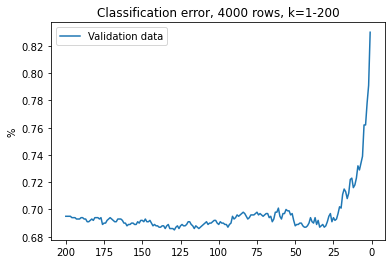

In [40]:
plot_KNN_model_4000()